In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open('topics.json', 'r') as f:
    topics = json.load(f)

In [3]:
len(topics)

67

## Counting

In [4]:
from collections import Counter

In [5]:
count = pd.Series(Counter([v for value in topics.values() for v in value]))

In [6]:
len(count)

347

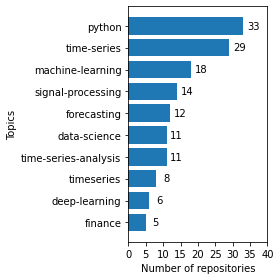

In [7]:
s = count.nlargest(10)
s = s.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(4,4))

rects = ax.barh(s.index, s.values)

ax.set_ylabel('Topics')
ax.set_xlabel('Number of repositories')
#ax.set_title('Number of repositories per topic')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(10, -5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)
ax.set_xlim(0,s.max()+3)
ax.set_xticks(list(range(0,int(s.max()+10),5)))
fig.tight_layout()

plt.savefig('../latex/images/nb-repos-per-topic.pdf')

## Coocurences of topics

In [11]:
cooccurence_matrix = pd.DataFrame(data=np.zeros((len(count), len(count))), index=count.index, columns=count.index)

In [12]:
for v in topics.values():
    for i in range(len(v) - 1):
        for j in range(i+1, len(v)):
            cooccurence_matrix.loc[v[i], v[j]] = 1 + cooccurence_matrix.loc[v[i], v[j]]
            cooccurence_matrix.loc[v[j], v[i]] = 1 + cooccurence_matrix.loc[v[j], v[i]]

In [13]:
(cooccurence_matrix.values == cooccurence_matrix.values.T).all()

True

In [14]:
max_coocc = pd.DataFrame(
    data=[(c, cooccurence_matrix[c].idxmax(), cooccurence_matrix[c].max()) for c in cooccurence_matrix.columns],
    columns = ['topic1', 'topic2', 'value']
)

In [15]:
max_coocc.sort_values(by='value', ascending=False).head(10)

,topic1,topic2,value
13,time-series,python,13.0
25,python,time-series,13.0
10,forecasting,time-series,11.0
1,machine-learning,time-series,10.0
2,signal-processing,python,8.0
40,data-science,time-series,7.0
34,time-series-analysis,time-series,7.0
86,deep-learning,machine-learning,5.0
88,time-series-forecasting,time-series,5.0
66,timeseries,python,5.0


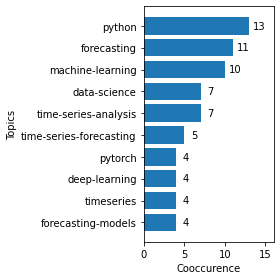

In [48]:
s = cooccurence_matrix['time-series'].nlargest(10)
s = s.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(4,4))

rects = ax.barh(s.index, s.values)

ax.set_ylabel('Topics')
ax.set_xlabel('Cooccurence')
#ax.set_title('Topics cooccuring with "time-series"')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{int(width)}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(10, -5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)
ax.set_xlim(0,s.max()+3)
ax.set_xticks(list(range(0,int(s.max()+5),5)))
fig.tight_layout()

plt.savefig('../latex/images/most-cooccuring-topics-time-series.pdf')

## Graph

In [16]:
import networkx as nx

In [17]:
n = cooccurence_matrix.shape[1]
nodes = cooccurence_matrix.columns
G = nx.Graph()

G.add_nodes_from(nodes)


for i in range(n - 1):
    for j in range(i + 1, n):
        weight=cooccurence_matrix.iloc[i,j]
        if weight > 0:
            G.add_edge(nodes[i], nodes[j], weight=weight)

In [18]:
# sanity check
G.get_edge_data(nodes[0], nodes[1]) == {'weight': cooccurence_matrix.iloc[0,1]}

True

In [19]:
# topics are all to all connected?
connected_components = list(nx.connected_components(G))
len(connected_components) == 1 and len(connected_components[0]) == len(count)

True

In [20]:
# degree
pd.Series(dict(nx.degree(G))).nlargest(10)

python                  209
time-series             178
machine-learning        105
signal-processing        96
forecasting              84
time-series-analysis     80
data-science             79
timeseries               53
trading                  51
scikit-learn             48
dtype: int64

## Clustering

In [22]:
from scipy.spatial.distance import squareform

In [23]:
cooccurence_vector = squareform(cooccurence_matrix.values)
distance_vector = 1. - cooccurence_vector / cooccurence_vector.max()

In [24]:
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram, fcluster, leaders

In [25]:
methods = ['single', 'complete', 'average', 'centroid', 'median', 'ward']
cophenetic_correlation = {}
for m in methods:
    linkage_matrix = linkage(y=distance_vector, method=m, metric='euclidean')
    c, _ = cophenet(linkage_matrix, distance_vector)
    cophenetic_correlation[m] = c

In [26]:
cophenetic_correlation

{'single': 0.4133847798986324,
 'complete': 0.6845245695710797,
 'average': 0.7644905082417475,
 'centroid': 0.26057394024851577,
 'median': 0.12170972280001201,
 'ward': 0.3073024101593642}

In [27]:
linkage_matrix = linkage(y=distance_vector, method='average', metric='euclidian')

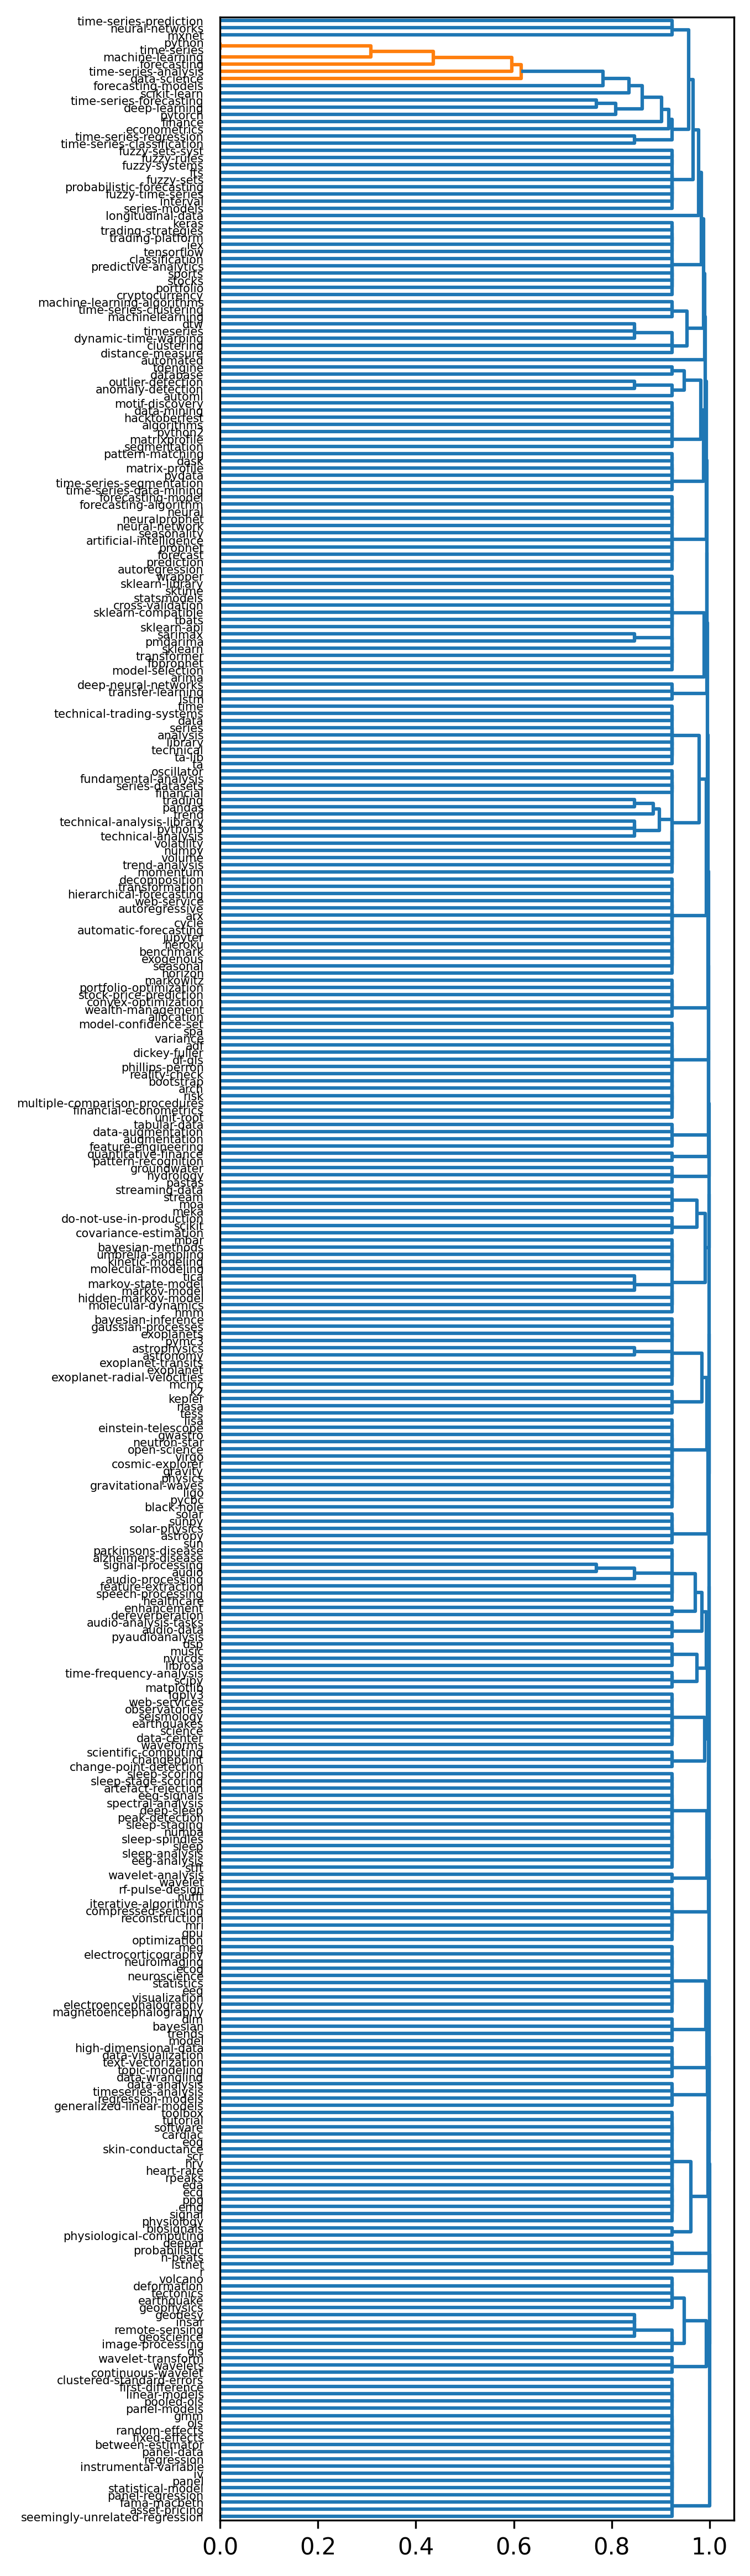

In [28]:
fig, ax = plt.subplots(figsize=(4,20), dpi=300)

dn = dendrogram(linkage_matrix, orientation='right', ax=ax, labels=cooccurence_matrix.columns) #, truncate_mode='lastp', distance_sort='descending')